## Pendahuluan

Dokumen ini merupakan kelanjutan dari analisis regresi OLS. Tujuannya adalah untuk membangun model regresi menggunakan metode **Weighted Least Squares (WLS)**. WLS adalah metode yang tepat digunakan ketika asumsi homoskedastisitas (varians sisaan yang konstan) pada model OLS tidak terpenuhi.

WLS bekerja dengan memberikan "bobot" yang berbeda pada setiap observasi. Observasi dengan varians sisaan yang lebih besar (kurang dapat diandalkan) akan diberi bobot lebih kecil, dan sebaliknya.

## 1. Memuat Paket dan Data

In [2]:
# Impor paket untuk manipulasi data
import pandas as pd
import numpy as np

# Impor paket untuk pemodelan statistik
import statsmodels.api as sm
import statsmodels.formula.api as smf
# PERBAIKAN: Impor het_white sebagai pengganti het_koenker
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Impor paket untuk uji statistik
from scipy import stats

# Impor paket untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Mengatur agar plot ditampilkan di dalam notebook
%matplotlib inline
sns.set_style('whitegrid')

### Mengimpor Data dari File Excel

In [3]:
# Ganti path file di bawah ini sesuai lokasi di komputer Anda!
file_path = "C:/Users/user/OneDrive - untirta.ac.id/R Script/Github_Regresi_OLS/data_simulasi_gls.xlsx"
data_WLS = pd.read_excel(file_path)

### Menampilkan Data yang Diimpor

In [4]:
data_WLS.head(6)

,y,x1,x2,x3,time
0,44.245264,1,63.957209,53.708923,1
1,35.033373,2,48.545686,37.719907,2
2,47.918691,3,50.852951,48.378023,3
3,59.391126,4,49.905935,60.880715,4
4,45.621889,5,66.817071,53.592014,5
5,76.923170,6,50.255130,60.671912,6


## 2. Model OLS Awal (Untuk Diagnosis)

Sebelum melakukan WLS, kita harus menjalankan model OLS terlebih dahulu untuk mengkonfirmasi adanya heteroskedastisitas. Sisaan dari model ini akan kita gunakan untuk diagnosis lebih lanjut.

In [5]:
# Membangun model OLS awal
model_ols_awal = smf.ols('y ~ x1 + x2 + x3', data=data_WLS).fit()

## 3. Uji Asumsi Klasik pada Model OLS
Kita akan melakukan serangkaian uji formal pada sisaan model OLS untuk memvalidasi asumsi-asumsinya.

#### Uji Normalitas (Shapiro-Wilk)

In [6]:
# Dapatkan sisaan dari model OLS
residuals_ols = model_ols_awal.resid

# Lakukan Uji Shapiro-Wilk
shapiro_test = stats.shapiro(residuals_ols)
print(f"--- Uji Normalitas (Shapiro-Wilk) ---")
print(f"Statistik Uji: {shapiro_test.statistic:.4f}, P-value: {shapiro_test.pvalue:.4f}")

--- Uji Normalitas (Shapiro-Wilk) ---
Statistik Uji: 0.9831, P-value: 0.2304


#### Uji Homoskedastisitas (Breusch-Pagan)

In [7]:
# Lakukan Uji Breusch-Pagan
bp_test = het_breuschpagan(residuals_ols, model_ols_awal.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print("--- Uji Homoskedastisitas (Breusch-Pagan) ---")
for label, value in zip(labels, bp_test):
    print(f"{label}: {value:.4f}")

--- Uji Homoskedastisitas (Breusch-Pagan) ---
LM Statistic: 20.1846
LM-Test p-value: 0.0002
F-Statistic: 8.0925
F-Test p-value: 0.0001


#### Uji Autokorelasi (Durbin-Watson)

In [8]:
# Hitung statistik Durbin-Watson
dw_stat = durbin_watson(residuals_ols)
print(f"--- Uji Autokorelasi (Durbin-Watson) ---")
print(f"Statistik D-W: {dw_stat:.4f}")

--- Uji Autokorelasi (Durbin-Watson) ---
Statistik D-W: 0.7408


#### Uji Multikolinearitas (VIF)

In [9]:
# Siapkan data untuk VIF
X = data_WLS[['x1', 'x2', 'x3']]
X = sm.add_constant(X, has_constant='add')

# Hitung VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print("--- Uji Multikolinearitas (VIF) ---")
print(vif_data[vif_data['feature'] != 'const'])

--- Uji Multikolinearitas (VIF) ---
  feature       VIF
1      x1  1.007994
2      x2  1.002954
3      x3  1.010958


## 4. Diagnosis Visual untuk Menentukan Sumber Heteroskedastisitas

Kita akan mem-plot nilai absolut dari sisaan terhadap setiap variabel independen untuk mencari pola "corong" yang dapat mengindikasikan sumber heteroskedastisitas.

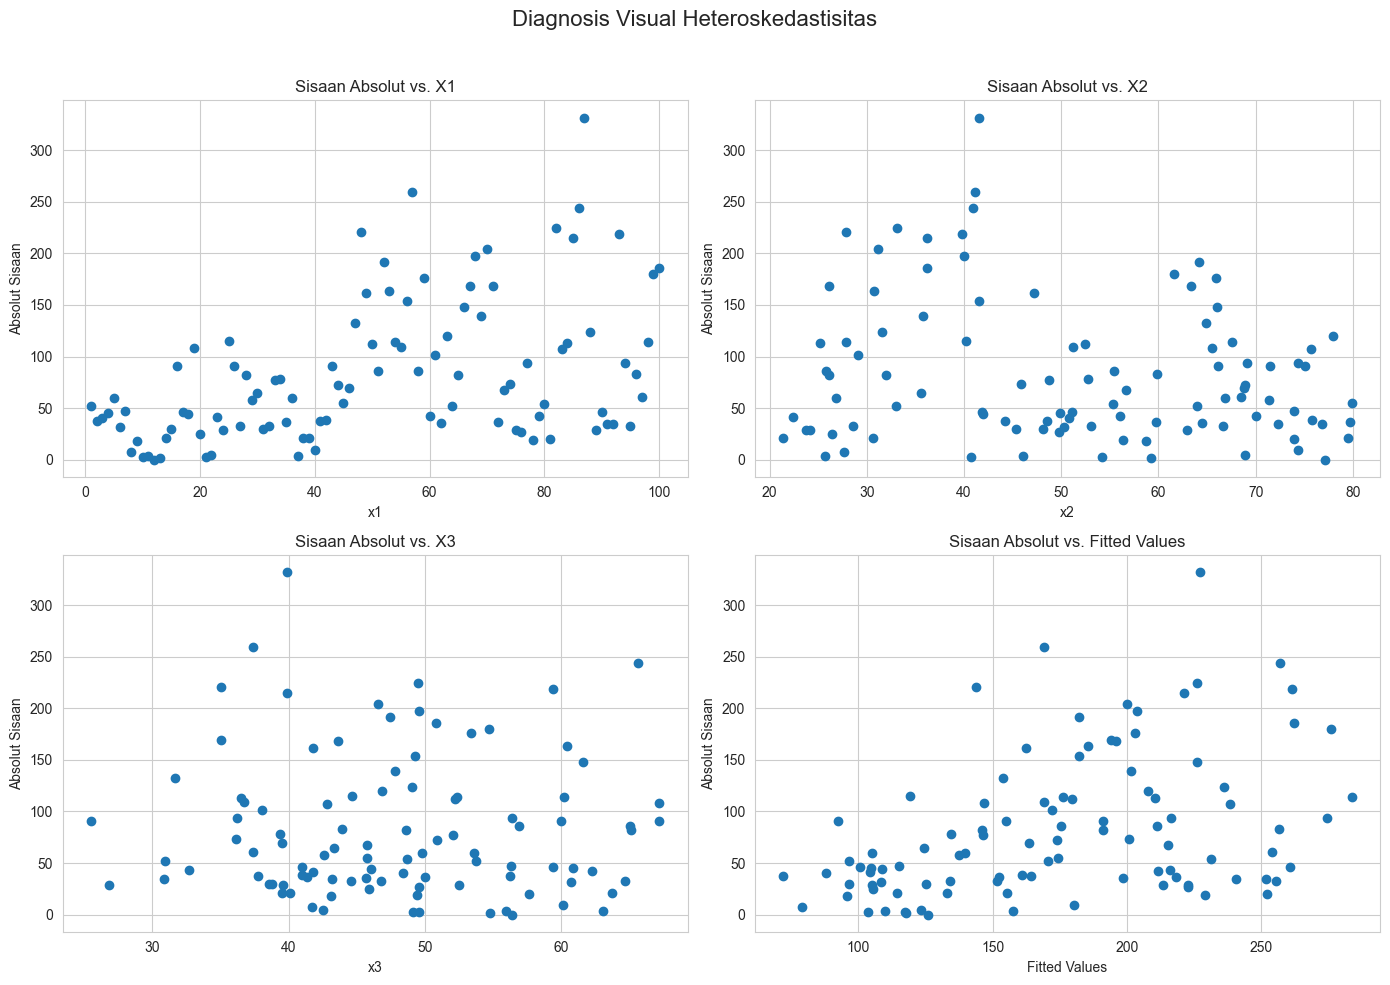

In [10]:
# Dapatkan nilai absolut sisaan dan nilai prediksi
sisaan_abs = np.abs(residuals_ols)
fitted_vals = model_ols_awal.fittedvalues

# Buat 4 plot diagnostik
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Diagnosis Visual Heteroskedastisitas', fontsize=16)

axes[0, 0].scatter(data_WLS['x1'], sisaan_abs)
axes[0, 0].set_title('Sisaan Absolut vs. X1')
axes[0, 0].set_xlabel('x1')
axes[0, 0].set_ylabel('Absolut Sisaan')

axes[0, 1].scatter(data_WLS['x2'], sisaan_abs)
axes[0, 1].set_title('Sisaan Absolut vs. X2')
axes[0, 1].set_xlabel('x2')
axes[0, 1].set_ylabel('Absolut Sisaan')

axes[1, 0].scatter(data_WLS['x3'], sisaan_abs)
axes[1, 0].set_title('Sisaan Absolut vs. X3')
axes[1, 0].set_xlabel('x3')
axes[1, 0].set_ylabel('Absolut Sisaan')

axes[1, 1].scatter(fitted_vals, sisaan_abs)
axes[1, 1].set_title('Sisaan Absolut vs. Fitted Values')
axes[1, 1].set_xlabel('Fitted Values')
axes[1, 1].set_ylabel('Absolut Sisaan')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 5. Keputusan Skema Pembobotan dan Pemodelan WLS

Berdasarkan analisis visual, pola corong paling jelas terlihat pada plot `Sisaan Absolut vs. X1`. Pola corong yang batas atasnya terlihat linear mengindikasikan bahwa standar deviasi sisaan sebanding dengan `x1`, sehingga varians sisaan sebanding dengan `x1^2`. Oleh karena itu, kita memilih skema pembobotan `w = 1 / x1^2`.

In [11]:
# Menghitung bobot berdasarkan x1^2
# Menambahkan nilai kecil (epsilon) untuk menghindari pembagian dengan nol jika ada x1=0
epsilon = 1e-8
bobot_wls = 1 / (data_WLS['x1']**2 + epsilon)

# Membangun model WLS menggunakan formula dan bobot
model_wls = smf.wls('y ~ x1 + x2 + x3', data=data_WLS, weights=bobot_wls).fit()

# Menampilkan ringkasan model WLS
print(model_wls.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.642
Model:                            WLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     57.45
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           2.36e-21
Time:                        16:12:25   Log-Likelihood:                -581.87
No. Observations:                 100   AIC:                             1172.
Df Residuals:                      96   BIC:                             1182.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.2586     14.775      0.491      0.6

## 6. Uji Asumsi Ulang pada Model WLS

Setelah membangun model WLS, kita wajib memeriksa kembali asumsi-asumsinya untuk memastikan metode ini berhasil memperbaiki masalah yang ada, terutama heteroskedastisitas.

In [12]:
# Dapatkan sisaan dari model WLS
residuals_wls = model_wls.resid

#### Uji Normalitas (Shapiro-Wilk) pada WLS

In [13]:
shapiro_wls = stats.shapiro(residuals_wls)
print(f"--- Uji Normalitas (Shapiro-Wilk) pada WLS ---")
print(f"Statistik Uji: {shapiro_wls.statistic:.4f}, P-value: {shapiro_wls.pvalue:.4f}")

--- Uji Normalitas (Shapiro-Wilk) pada WLS ---
Statistik Uji: 0.9357, P-value: 0.0001


#### Uji Homoskedastisitas (Breusch-Pagan) pada WLS
Kita berharap *p-value* dari uji ini sekarang tidak lagi signifikan (> 0.05), yang menandakan masalah heteroskedastisitas sudah teratasi.

In [20]:
# --- Uji Homoskedastisitas (Breusch-Pagan) pada WLS ---

# 1. Dapatkan akar kuadrat dari bobot
sqrt_weights = np.sqrt(bobot_wls)

# 2. Siapkan variabel dependen (y) dan independen (X) dari data asli
X = data_WLS[['x1', 'x2', 'x3']]
X = sm.add_constant(X, has_constant='add')
y = data_WLS['y']

# 3. Transformasikan variabel
X_transformed = X.multiply(sqrt_weights, axis=0)
y_transformed = y * sqrt_weights

# 4. Buat model OLS pada data yang sudah ditransformasi untuk mendapatkan sisaan WLS yang tepat
model_transformed_ols = sm.OLS(y_transformed, X_transformed).fit()

# 5. Jalankan Uji Breusch-Pagan menggunakan sisaan dari model transformasi,
#    TETAPI terhadap variabel X ASLI (dari model OLS awal).
bp_wls_correct = het_breuschpagan(model_transformed_ols.resid, model_ols_awal.model.exog)

print("--- Uji Homoskedastisitas (Breusch-Pagan) pada WLS ---")
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
for label, value in zip(labels, bp_wls_correct):
    print(f"{label}: {value:.4f}")

--- Uji Homoskedastisitas (Breusch-Pagan) pada WLS ---
LM Statistic: 1.7198
LM-Test p-value: 0.6325
F-Statistic: 0.5600
F-Test p-value: 0.6427


#### Uji Autokorelasi (Durbin-Watson) pada WLS

In [21]:
# Hitung statistik Durbin-Watson pada sisaan WLS
dw_wls = durbin_watson(model_wls.resid)
print(f"--- Uji Autokorelasi (Durbin-Watson) pada WLS ---")
print(f"Statistik D-W: {dw_wls:.4f}")

--- Uji Autokorelasi (Durbin-Watson) pada WLS ---
Statistik D-W: 0.6147


#### Uji Multikolinearitas (VIF) pada WLS
Nilai VIF tidak dipengaruhi oleh pembobotan, sehingga hasilnya akan sama dengan model OLS.

In [25]:
# VIF dihitung pada data X yang sama seperti pada model OLS
# Kita bisa menampilkan kembali DataFrame vif_data yang sudah dibuat sebelumnya
print("--- Uji Multikolinearitas (VIF) ---")
print(vif_data[vif_data['feature'] != 'const'])

--- Uji Multikolinearitas (VIF) ---
  feature       VIF
1      x1  1.007994
2      x2  1.002954
3      x3  1.010958


## 7. Evaluasi Kebaikan Model (Goodness-of-Fit)

In [26]:
# Ekstrak metrik dari model WLS
# Catatan: R-squared pada WLS harus diinterpretasikan dengan hati-hati
r_squared_wls = model_wls.rsquared
adj_r_squared_wls = model_wls.rsquared_adj
model_aic_wls = model_wls.aic
model_bic_wls = model_wls.bic

# Buat DataFrame untuk menampilkan hasil
evaluasi_data_wls = {
    'Metrik': ['R-squared', 'Adjusted R-squared', 'AIC', 'BIC'],
    'Nilai': [r_squared_wls, adj_r_squared_wls, model_aic_wls, model_bic_wls]
}
evaluasi_df_wls = pd.DataFrame(evaluasi_data_wls)

print("Metrik Kebaikan Model (Goodness-of-Fit) untuk WLS")
evaluasi_df_wls

Metrik Kebaikan Model (Goodness-of-Fit) untuk WLS


,Metrik,Nilai
0,R-squared,0.642266
1,Adjusted R-squared,0.631087
2,AIC,1171.746839
3,BIC,1182.167520
